# Rolling Fourier Ring Correlation Map

A quick notebook implementation of rolling Fourier Ring Correlation (rFRC) map.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from skimage import filters
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import pandas as pd
from scipy.fftpack import fft2, fftshift, ifft2

# Add the relative path to ../SRmetric
sys.path.append(os.path.abspath(os.path.join('..')))

from SRmetric.metric import *
from SRmetric.utils import *

## Load Image

In [2]:
WF_PATH = "../data/tirf-sim/HighNA/RBLCell6_pc50pw50_NA160_cyc3_20241031_130414_WF.tif"
SR_PATH = "../data/tirf-sim/HighNA/RBLCell6_pc50pw50_NA160_cyc3.mrc"

# WF_PATH = "../data/tirf-sim/HighNA/RBLCell12_pc50pw50_768NA160_cyc3_20241031_145214_WF.tif"
# SR_PATH = "../data/tirf-sim/HighNA/RBLCell12_pc50pw50_768NA160_cyc3.mrc"

In [3]:
wf_img = im_read(WF_PATH)
sr_img = im_read(SR_PATH)

print(wf_img.shape)
print(sr_img.shape)

voxel size: (0.03065, 0.03065, 0.05)
(1024, 1024)
(3, 1024, 1024)


/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:238: RuntimeWarning: Machine stamp '0x00 0x00 0x00 0x00' does not match the apparent byte order '>'
  warnings.warn(msg.format(pretty_machst, header.mode.dtype.byteorder),


## Plot Self Rolling FRC

Processing self FRC resolution patches: 100%|██████████| 841/841 [00:00<00:00, 1023.66it/s]
/tmp/ipykernel_2420995/2548747664.py:596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


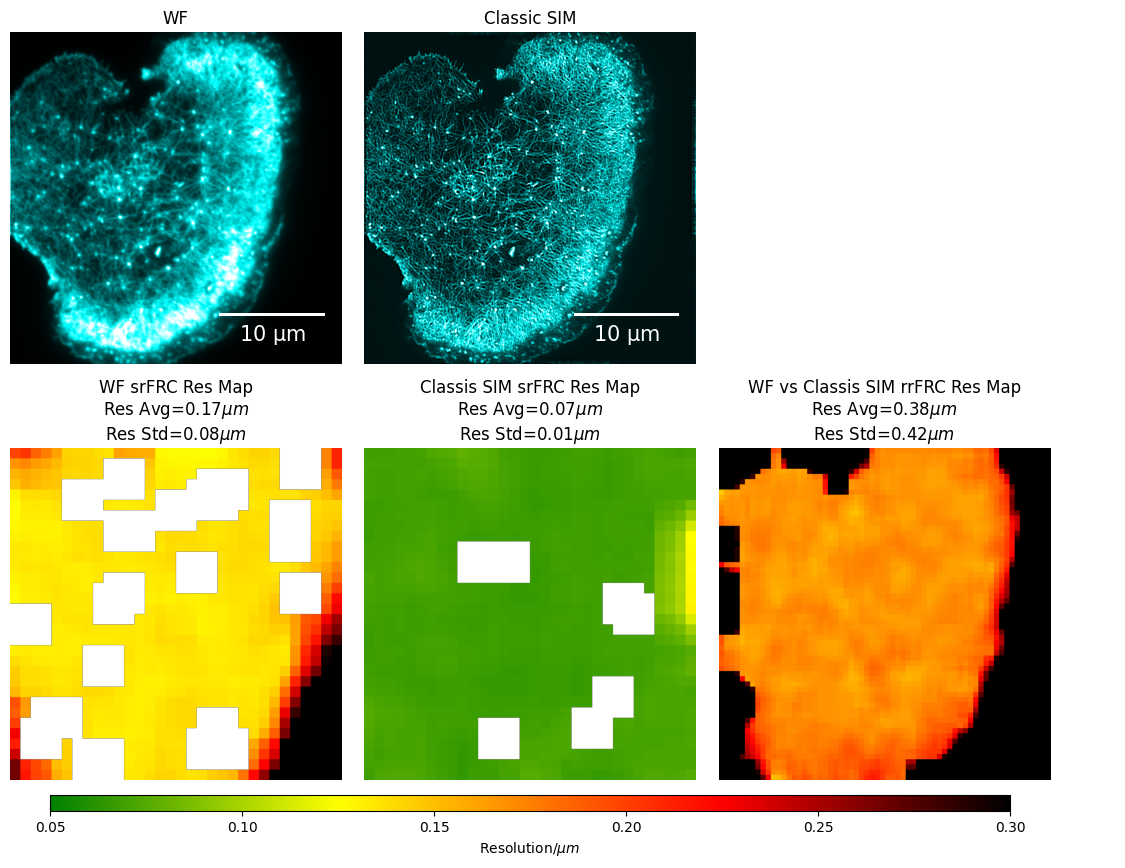

In [84]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Try importing CuPy
try:
    import cupy as cp
    GPU_AVAILABLE = cp.is_available()
except ImportError:
    GPU_AVAILABLE = False

class ResolutionMap:
    """
    A Python class object to compute superresolution quality metric

    Attributes:
    -----------
    img1: numpy.ndarray
        2D numpy array of image to compute resolution
    img2: numpy.ndarray (optional)
        2D numpy array of processed image. Necessary only for relative rolling FRC between two images of same size.
    window_size: int (default=32)
        Size of the sliding window.
    stride: int (default=16)
        Stride between windows.
    frc_threshold: float (default=1/7)
        Threshold to determine resolution from FRC.
    frc_bins: int (default=50)
        Number of bins for FRC calculation
    sampling: int (default=1)
        Sampling rate if the image has been pre-upsampled
    sampling_method: str (default="max")
        Downsampling method, choose from ["max","skipping","Fourier"]
    pixel_size: float (default=1)
        Physical pixel size of the image, in um
    export_dir: str (default=None)
        Result export directory, only export results if the value is not None
    """

    def __init__(self, 
                img1,
                img2 = None,
                window_size = 32,
                stride = 16,
                frc_threshold = 1/7,
                frc_bins = 50,
                sampling = 1,
                samping_method = "max",
                pixel_size=1,
                export_dir=None,
                verbose = True,
                ):
        assert len(img1.shape) == 2, "img1 must be a 2D numpy array"
        self.img1 = img1
        if img2 is not None:
            assert len(img2.shape) == 2, "img2 must be a 2D numpy array"
            assert img1.shape == img2.shape, "Both images must have the same shape."
        self.img2 = img2

        self.window_size=window_size
        self.stride=stride
        self.frc_threshold=frc_threshold
        self.frc_bins=frc_bins
        self.sampling=sampling
        self.sampling_method=samping_method
        self.pixel_size=pixel_size
        self.export_dir = export_dir
        if self.export_dir is not None:
            os.makedirs(self.export_dir,exist_ok=True)
        self.verbose = verbose

        # automatically detect to use gpu
        self.use_gpu = GPU_AVAILABLE
        self.backend = cp if self.use_gpu else np

        if self.use_gpu:
            if verbose:
                print("CUDA GPU detected, running on GPU")
                self.img1 = cp.asarray(img1)
                if img2 is not None:
                    self.img2 = cp.asarray(img2)
            else:
                print("CUDA GPU not available, running on CPU")

        self.ring_radii = self.backend.arange(1,window_size//2)
        self.resolution_map = self.backend.zeros_like(self.img1, dtype=self.backend.float32)
        self.weight_map = self.backend.zeros_like(self.img1, dtype=self.backend.float32)

    def rolling_window(self, img1, img2, flip_tile=False):
        """
        Generate rolling window patches from the image.
        """
        h, w = img1.shape
        windows = []
        for i in range(0, h - self.window_size + 1, self.stride):
            for j in range(0, w - self.window_size + 1, self.stride):
                patch1 = img1[i:i+self.window_size, j:j+self.window_size]
                patch2 = img2[i:i+self.window_size, j:j+self.window_size]
                windows.append((patch1,patch2,(i,j),flip_tile))
        return windows

    def compute_resolution(self, frc_values):
        """
        Determine the resolution where FRC falls below the threshold.

        Parameters:
            frc_values (ndarray): Array of FRC values.

        Returns:
            int: Index of the frequency ring corresponding to resolution.
        """
        for i, frc in enumerate(frc_values):
            if frc < self.frc_threshold:
                # Calculate spatial frequency: (i+1) accounts for 1-based ring index
                spatial_frequency = (i + 1) / (self.window_size * self.pixel_size)
                return 1 / spatial_frequency  # Return spatial resolution in physical units

        # If threshold is never crossed, return the coarsest resolution
        spatial_frequency = len(frc_values) / (self.window_size * self.pixel_size)
        return 1 / spatial_frequency

    def fourier_ring_correlation(self, img1, img2, flip_tile=False):
        """
        Compute the Fourier Ring Correlation (FRC) between two images.

        Parameters:
            img1 (ndarray): First image (windowed region).
            img2 (ndarray): Second image (windowed region).
            flip_tile (book): Perform flipped tiling before FFT

        Returns:
            frc_values (ndarray): FRC values for each ring radius.
        """
        backend = self.backend
        if flip_tile:
            img1 = image_flip_tile(img1)
            img2 = image_flip_tile(img2)

        F1 = backend.fft.fftshift(backend.fft.fft2(img1))
        F2 = backend.fft.fftshift(backend.fft.fft2(img2))

        mag1 = self.backend.abs(F1)
        mag2 = self.backend.abs(F2)

        # Create coordinate grid
        ny, nx = F1.shape
        y, x = self.backend.indices((ny, nx)) - self.backend.array([ny // 2, nx // 2])[:, None, None]
        radius = self.backend.sqrt(x**2 + y**2)
        max_radius = self.backend.min([ny, nx]) // 2  # Nyquist limit

        # Bin frequencies into rings
        bins = self.backend.linspace(0, max_radius, self.frc_bins//self.sampling + 1)
        frc_values = []
        for i in range(len(bins) - 1):
            # Mask for the current ring
            mask = (radius >= bins[i]) & (radius < bins[i+1])
            num_points = self.backend.sum(mask)
            if num_points > 0:
                # Compute FRC for the ring
                numerator = self.backend.sum((F1[mask] * np.conj(F2[mask])).real)
                denominator = self.backend.sqrt(np.sum(mag1[mask]**2) * self.backend.sum(mag2[mask]**2))
                frc_values.append(numerator / denominator)
            else:
                frc_values.append(0)

        # Calculate frequencies as the midpoints of bins
        frequencies = (bins[:-1] + bins[1:]) / 2 / max_radius  # Normalized frequency

        # Find the first frequency where FRC drops below frc_threshold
        crossing_index = self.backend.where(self.backend.array(frc_values) < self.frc_threshold)[0]
        if len(crossing_index) > 0:
            frc_cross_frequency = frequencies[crossing_index[0]]

            # Convert normalized frequency to spatial frequency
            spatial_frequency = frc_cross_frequency * (1 / (2 * self.pixel_size * self.sampling))

            # Convert spatial frequency to resolution
            resolution = 1 / spatial_frequency
        else:
            resolution = self.backend.nan
            frc_cross_frequency = self.backend.nan

        return frequencies, self.backend.array(frc_values), resolution, frc_cross_frequency

        # # Create radial rings
        # ny, nx = img1.shape
        # y, x = backend.indices((ny, nx))
        # center_y, center_x = ny // 2, nx // 2
        # r = backend.sqrt((x - center_x)**2 + (y - center_y)**2)

        # frc_values = []
        # for radius in self.ring_radii:
        #     mask = (r >= radius - 0.5) & (r < radius + 0.5)
        #     F1_ring = F1[mask]
        #     F2_ring = F2[mask]

        #     numerator = backend.sum(F1_ring * backend.conj(F2_ring))
        #     denominator = backend.sqrt(backend.sum(backend.abs(F1_ring)**2) * backend.sum(backend.abs(F2_ring)**2))
        #     frc = backend.abs(numerator) / (denominator + 1e-8)
        #     frc_values.append(frc)

        # return backend.array(frc_values)

    def process_patch(self, args):
        """Process a single patch for resolution computation."""
        patch1, patch2, position, flip_tile = args
        freq, frc_val, resolution, frc_cross_freq = self.fourier_ring_correlation(patch1, patch2, flip_tile=flip_tile)

        # export result
        if self.export_dir is not None:
            fig, axs = plt.subplots(3,2,figsize=(8,12))
            axs[0,0].imshow(patch1,vmin=np.percentile(patch1,1),vmax=np.percentile(patch1,99.5),cmap=cyan_hot_cmap)
            axs[0,0].set_axis_off()
            axs[0,0].set_title("img0")
            # Add a scale bar
            scalebar = ScaleBar(self.pixel_size, 
                                units="um",
                                location="lower right",
                                color="white",
                                # length_fraction=0.4,
                                label_loc="top",
                                width_fraction=0.01,
                                # fixed_value=1,
                                border_pad=1,
                                # pad=0.2,
                                frameon=False,
                                font_properties={"size":15},
                                ) 
            axs[0,0].add_artist(scalebar)

            axs[0,1].imshow(patch2,vmin=np.percentile(patch2,1),vmax=np.percentile(patch2,99.5),cmap=cyan_hot_cmap)
            axs[0,1].set_axis_off()
            axs[0,1].set_title("img1")
            # Add a scale bar
            scalebar = ScaleBar(self.pixel_size, 
                                units="um",
                                location="lower right",
                                color="white",
                                # length_fraction=0.4,
                                label_loc="top",
                                width_fraction=0.01,
                                # fixed_value=1,
                                border_pad=1,
                                # pad=0.2,
                                frameon=False,
                                font_properties={"size":15},
                                ) 
            axs[0,1].add_artist(scalebar)

            # plot the power spectrum of the input images
            if flip_tile:
                fft_1  = fftshift(fft2(image_flip_tile(patch1)))
            else:
                fft_1 = fftshift(fft2(patch1))
            mag1 = np.abs(fft_1)
            power_spectrum1 = np.log(1 + mag1**2)
            # axs[1,2].imshow(power_spectrum1, cmap='viridis')
            axs[1,0].imshow(power_spectrum1, cmap='viridis', extent=(-1, 1, -1, 1))
            axs[1,0].set_title('FFT Power Spectrum: img0')
            axs[1,0].set_xlabel('Normalized Frequency (x)')
            axs[1,0].set_ylabel('Normalized Frequency (y)')

            # plot the power spectrum of the input images
            if flip_tile:
                fft_2  = fftshift(fft2(image_flip_tile(patch2)))
            else:
                fft_2 = fftshift(fft2(patch2))
            mag2 = np.abs(fft_2)
            power_spectrum2 = np.log(1 + mag2**2)
            # axs[1,2].imshow(power_spectrum1, cmap='viridis')
            axs[1,1].imshow(power_spectrum2, cmap='viridis', extent=(-1, 1, -1, 1))
            axs[1,1].set_title('FFT Power Spectrum: img1')
            axs[1,1].set_xlabel('Normalized Frequency (x)')
            axs[1,1].set_ylabel('Normalized Frequency (y)')

            label = "FIRE = {:.2f} um)".format(resolution)
            axs[2,0].plot(freq*(1/(self.pixel_size*self.sampling)), frc_val, marker='o',label=label)
            # axs[2,0].set_title('Self FRC' , fontsize=14)
            axs[2,0].set_xlabel(r'Spatial Frequency / $\mu m^{-1}$', fontsize=12)
            axs[2,0].set_ylabel('FRC', fontsize=12)
            axs[2,0].grid(True)
            axs[2,0].set_xlim([0, 1.05*(1/(self.pixel_size*self.sampling))])
            axs[2,0].set_ylim([0, 1.05])
            axs[2,0].axhline(y=self.frc_threshold, color='r', linestyle='--', label=f'Resolution Limit')
            axs[2,0].legend(loc='lower left')  # Include both lines in the legend

            fig.tight_layout()

            os.makedirs(os.path.join(self.export_dir,"rrFRC"),exist_ok=True)
            fig.savefig(os.path.join(self.export_dir,"rrFRC","rrFRC_{:04}_{:04}".format(position[0],position[1])))

        return position, resolution

    def process_srFRC_patch(self,args):
        """Process a single patch for srFRC resolution computation."""
        
        freq = []
        frc_values = []
        resolution = []
        frc_cross_freq = []
        for i, args_ in enumerate(args):
            patch1, patch2, position, flip_tile = args_
            freq_, frc_values_, resolution_, frc_cross_freq_ = self.fourier_ring_correlation(patch1, patch2, flip_tile=flip_tile)
            freq.append(freq_)
            frc_values.append(frc_values_)
            resolution.append(resolution_)
            frc_cross_freq.append(frc_cross_freq_)

         # Find the first frequency where FRC drops below frc_threshold
        crossing_index = self.backend.where(self.backend.mean(frc_values,axis=0) < self.frc_threshold)[0]
        if len(crossing_index) > 0:
            frc_cross_frequency = self.backend.mean(freq, axis=0)[crossing_index[0]]

            # Convert normalized frequency to spatial frequency
            spatial_frequency = frc_cross_frequency * (1 / (2 * self.pixel_size *self.sampling))

            # Convert spatial frequency to resolution
            resolution_all = 1 / spatial_frequency
        else:
            resolution_all = self.backend.nan

        if self.export_dir is not None:
            fig, axs = plt.subplots(2,5,figsize=(20,8))

            for i in range(2):
                for j in range(2):
                    axs[0,i*2+j].imshow(args[i][j],vmin=np.percentile(args[i][j],1),vmax=np.percentile(args[i][j],99.5),cmap=cyan_hot_cmap)
                    # axs[0,0].set_axis_off()
                    axs[0,i*2+j].set_title("img{}{}".format(i,j))
                    # Add a scale bar
                    scalebar = ScaleBar(self.pixel_size*2*self.sampling, 
                                        units="um",
                                        location="lower right",
                                        color="white",
                                        # length_fraction=0.4,
                                        label_loc="top",
                                        width_fraction=0.01,
                                        # fixed_value=1,
                                        border_pad=1,
                                        # pad=0.2,
                                        frameon=False,
                                        font_properties={"size":15},
                                        ) 
                    axs[0,i*2+j].add_artist(scalebar)

                    # plot the power spectrum of the input images
                    if flip_tile:
                        fft  = fftshift(fft2(image_flip_tile(args[i][j])))
                    else:
                        fft = fftshift(fft2(args[i][j]))
                    mag = np.abs(fft)
                    power_spectrum = np.log(1 + mag**2)
                    # axs[1,2].imshow(power_spectrum1, cmap='viridis')
                    axs[1,i*2+j].imshow(power_spectrum, cmap='viridis', extent=(-1, 1, -1, 1))
                    axs[1,i*2+j].set_title('FFT Power Spectrum: img{}{}'.format(i,j))
                    axs[1,i*2+j].set_xlabel('Normalized Frequency (x)')
                    axs[1,i*2+j].set_ylabel('Normalized Frequency (y)')

                label = "FRC{} (FIRE = {:.2f} um)".format(i, resolution[i])
                axs[1,4].plot(freq[i]*(1/(self.pixel_size*self.sampling)), frc_values[i], marker='o',label=label)

            label = "FRC (FIRE = {:.2f} um)".format(resolution_all)

            axs[1,4].plot(self.backend.mean(freq, axis=0)*(1/(self.pixel_size*self.sampling)), self.backend.mean(frc_values, axis=0), marker='o',label=label)
            axs[1,4].set_xlabel(r'Spatial Frequency / $\mu m^{-1}$', fontsize=12)
            axs[1,4].set_ylabel('FRC', fontsize=12)
            axs[1,4].grid(True)
            axs[1,4].set_xlim([0, 1.05*(1/(self.pixel_size*self.sampling))])
            axs[1,4].axhline(y=self.frc_threshold, color='r', linestyle='--', label=f'Resolution Limit')
            axs[1,4].legend(loc='lower left')  # Include both lines in the legend

            fig.tight_layout()

            os.makedirs(os.path.join(self.export_dir,"srFRC"),exist_ok=True)
            fig.savefig(os.path.join(self.export_dir,"srFRC","srFRC_{:04}_{:04}".format(position[0],position[1])))

        return position, resolution_all

    @staticmethod
    def _init_worker(instance):
        """Initialize workers with a class instance."""
        global obj
        obj = instance

    @staticmethod
    def _process_patch_proxy(args):
        """Proxy to call the instance's worker function."""
        return obj.process_patch(args) 
    
    @staticmethod
    def _process_srFRC_patch_proxy(args):
        """Proxy to call the instance's worker function."""
        return obj.process_srFRC_patch(args) 

    def compute_srFRC_map(self):
        """
        Compute self rolling FRC of image 1
        """

        if self.sampling_method == "max":
            # Ensure the array dimensions are divisible by 2
            assert self.img1.shape[0] % self.sampling == 0 and self.img1.shape[1] % self.sampling == 0, "Array dimensions must be divisible by sampling rate {}.".format(sampling_rate[i])

            # Reshape the array then perform max pooling
            reshaped = self.img1.reshape(self.img1.shape[0] // self.sampling, self.sampling, self.img1.shape[1] // self.sampling, self.sampling)
            img = reshaped.max(axis=(1, 3))
        elif self.sampling_method == "Foruier":
            img_fft = self.backend.fftshift(self.backend.fft2(self.img1))
            img_fft_cropped = img_fft[
                (img_fft.shape[0] - img_fft.shape[0]//self.sampling)//2:(img_fft.shape[0] + img_fft.shape[0]//self.sampling)//2,
                (img_fft.shape[1] - img_fft.shape[1]//self.sampling)//2:(img_fft.shape[1] + img_fft.shape[1]//self.sampling)//2,
            ]
            img = self.backend.abs(self.backend.ifft2(img_fft_cropped))

        if self.sampling_method in ["max", "Fourier"]:
            # first pixel offset  
            img00 = img[::2, ::2]
            img01 = img[1::2, 1::2]
            
            # second pixel offset
            img10 = img[1::2,0::2]
            img11 = img[0::2,1::2]
        elif self.sampling_method == "skipping":
            # first pixel offset  
            img00 = self.img1[0::int(2*self.sampling),0::int(2*self.sampling)]
            img01 = self.img1[1*self.sampling::int(2*self.sampling),1*self.sampling::int(2*self.sampling)]

            # second pixel offset
            img00 = self.img1[1*self.sampling::int(2*self.sampling),0::int(2*self.sampling)]
            img01 = self.img1[0::int(2*self.sampling),1*self.sampling::int(2*self.sampling)]

        windows0 = self.rolling_window(img00,img01, flip_tile=True)
        windows1 = self.rolling_window(img10,img11, flip_tile=True)

        windows = []
        for win0_, win1_ in zip(windows0,windows1):
            windows.append((win0_, win1_))

        if self.use_gpu:
            raise NotImplementedError("srFRC with gpu not implemented")
        else:
            # CPU parallel processing using multiprocessing
            with Pool(processes=cpu_count(), initializer=self._init_worker, initargs=(self,)) as pool:
                for position, resolution in tqdm(pool.imap_unordered(self._process_srFRC_patch_proxy,windows),total=len(windows),desc="Processing self FRC resolution patches"):
                    i, j = position
                    if resolution != self.backend.nan:
                        self.resolution_map[i*self.sampling*2:(i+self.window_size)*self.sampling*2,j*self.sampling*2:(j+self.window_size)*self.sampling*2] += resolution
                        self.weight_map[i*self.sampling*2:(i+self.window_size)*self.sampling*2,j*self.sampling*2:(j+self.window_size)*self.sampling*2] += 1
        
        # Normalize resolution map by weight map
        self.resolution_map = self.resolution_map / (self.weight_map + 1e-8)  # Avoid division by zero

        if self.use_gpu:
            return cp.asnumpy(self.resolution_map)
        else:
            return self.resolution_map

    def compute_rrFRC_map(self):
        """
        Compute relative rolling FRC between input images 1 and 2
        """
        if self.img2 is None:
            raise AssertionError("Image 2 not provided")
        
        windows = self.rolling_window(self.img1, self.img2, flip_tile=True)

        if self.use_gpu:
            # GPU inherently runs parallel
            for patch1, patch2, position in windows:
                position, resolution = self.process_patch((patch1, patch2, position))
                i, j = position
                self.resolution_map[i:i+self.window_size, j:j+self.window_size] = resolution
                self.weight_map[i:i+self.window_size, j:j+self.window_size] += 1
        else:
            # CPU parallel processing using multiprocessing
            with Pool(processes=cpu_count(), initializer=self._init_worker, initargs=(self,)) as pool:
                for position, resolution in tqdm(pool.imap_unordered(self._process_patch_proxy,windows),total=len(windows),desc="Processing FRC resolution patches"):
                    i, j = position
                    if resolution != self.backend.nan:
                        self.resolution_map[i:i+self.window_size, j:j+self.window_size] += resolution
                        self.weight_map[i:i+self.window_size, j:j+self.window_size] += 1

        # Normalize resolution map by weight map
        self.resolution_map = self.resolution_map / (self.weight_map + 1e-8)  # Avoid division by zero

        if self.use_gpu:
            return cp.asnumpy(self.resolution_map)
        else:
            return self.resolution_map

PX_SIZE = 0.03065
SAMPLING_RATE= 1

# rrFRC
rm = ResolutionMap(
    wf_img,
    sr_img[0],
    pixel_size=PX_SIZE,
    window_size=64,
    stride=16,
    # export_dir="../res"
    )

rrFRC_map = rm.compute_rrFRC_map()

# srFRC for image 1
rm1 = ResolutionMap(
    wf_img,
    pixel_size=PX_SIZE,
    sampling=2,
    window_size=32,
    stride=8,
    # export_dir="../res/wf"
    )
srFRC_map_1 = rm1.compute_srFRC_map()

# srFRC for image 2
rm2 = ResolutionMap(
    sr_img[0],
    pixel_size=PX_SIZE,
    sampling=1,
    window_size=64,
    stride=16,
    # export_dir="../res/sr"
    )
srFRC_map_2 = rm2.compute_srFRC_map()

fig, axs = plt.subplots(2,3,figsize=(12,8))
axs[0,0].imshow(wf_img,vmin=np.percentile(wf_img,1),vmax=np.percentile(wf_img,99.5),cmap=cyan_hot_cmap)
axs[0,0].set_axis_off()
axs[0,0].set_title("WF")
# Add a scale bar
scalebar = ScaleBar(PX_SIZE, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,0].add_artist(scalebar)

axs[0,1].imshow(sr_img[0],vmin=np.percentile(sr_img[0],1),vmax=np.percentile(sr_img[0],99.5),cmap=cyan_hot_cmap)
axs[0,1].set_axis_off()
axs[0,1].set_title("Classic SIM")
# Add a scale bar
scalebar = ScaleBar(PX_SIZE, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,1].add_artist(scalebar)

axs[0,2].set_axis_off()

# im0 = axs[1,0].imshow(srFRC_map_1,cmap=res_cmap)
im0 = axs[1,0].imshow(srFRC_map_1,vmin=0.05,vmax=0.3,cmap=res_cmap)
axs[1,0].set_axis_off()
axs[1,0].set_title(r"WF srFRC Res Map"
                   "\nRes Avg={:.2f}$\mu m$"
                   "\nRes Std={:.2f}$\mu m$".format(np.nanmean(srFRC_map_1),np.nanstd(srFRC_map_1))
                   )

im1 = axs[1,1].imshow(srFRC_map_2,vmin=0.05,vmax=0.3,cmap=res_cmap)
axs[1,1].set_axis_off()
axs[1,1].set_title(r"Classis SIM srFRC Res Map"
                   "\nRes Avg={:.2f}$\mu m$"
                   "\nRes Std={:.2f}$\mu m$".format(np.nanmean(srFRC_map_2),np.nanstd(srFRC_map_2))
                   )


im2 = axs[1,2].imshow(rrFRC_map,vmin=0.05,vmax=0.3,cmap=res_cmap)
axs[1,2].set_axis_off()
axs[1,2].set_title(r"WF vs Classis SIM rrFRC Res Map"
                   "\nRes Avg={:.2f}$\mu m$"
                   "\nRes Std={:.2f}$\mu m$".format(np.mean(rrFRC_map),np.nanstd(rrFRC_map))
                    )

fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.1, -0.02, 0.8, 0.02]) # figure normalized x, y, w, h
cbar = fig.colorbar(im2, cax=cbar_ax,orientation="horizontal") 
cbar.set_label(r"Resolution/$\mu m$")

fig.tight_layout()